In [1]:
cd /home/c01muya/vae-disentanglement/disentanglement_lib_pl

/home/c01muya/vae-disentanglement/disentanglement_lib_pl


In [2]:
cd D:\\Saarbrucken\\EDA_Research\\vae-disentanglement\\disentanglement_lib_pl

D:\Saarbrucken\EDA_Research\vae-disentanglement\disentanglement_lib_pl


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns

import torch
import torchvision.utils as vutils
import torchvision.transforms.functional as T
from torch.utils.data import DataLoader
from torchvision import transforms

from bvae_experiment import BVAEExperiment
from common.data_loader import DSpritesDataset, ThreeShapesDataset, ContinumDataset
from common.notebook_utils import *
from common.utils import CenteredNorm
# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})
np.set_printoptions(suppress=True,precision=4)

In [4]:
def model_and_activations(current_device,  dataset, checkpoint_path, activation_type,
                          batch_size=64, beta=1.0, z_dim=10, l_dim=6, num_batches=1):
    
    activations, full_dataset, model = load_model_and_data_and_get_activations(
                        dset_name=dataset, dset_path='../datasets', 
                        batch_size=batch_size, z_dim=z_dim , beta=beta, 
                        checkpoint_path=checkpoint_path, current_device=current_device, 
                        activation_type=activation_type, seed=123,  batches=num_batches, l_zero_reg=False, l_dim=l_dim
        )

    data_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle = False,drop_last=True)

    return model, activations, data_loader

# Correlation 0.2 Beta 2

In [3]:
current_device = torch.device("cuda:3")
dataset='dsprites_full'
checkpoint_path="../train-logs/jscmodel/epoch=25-step=299520.ckpt"

model_and_activations(current_device,  dataset, checkpoint_path)

Experiment class: cpu
Model class: cpu
Loaded 737280 images


  0%|▏                                                                                                                                                                                                   | 10/10368 [00:01<24:24,  7.07it/s]


In [4]:
img, labels = next(dsprites_full_loader.__iter__())


In [54]:
diffs = check_correlated_dimensions(img.to(current_device), model_dsprites_full, current_device)


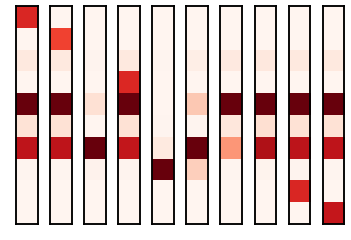

In [48]:
visualize_change(diffs[0])

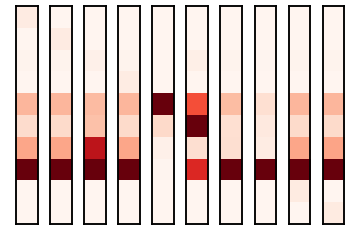

In [49]:
visualize_change(diffs[1])

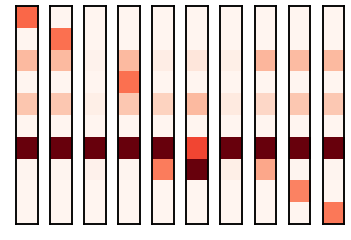

In [51]:
visualize_change(diffs[3])

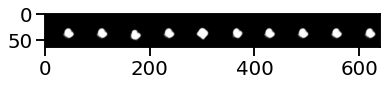

In [69]:
import torchvision.utils as vutils

recons_side_by_side = torch.cat(diffs[0][3].chunk(10, dim=0), dim = 3)
img_input_vs_recon = vutils.make_grid(recons_side_by_side, normalize=True, value_range=(0.0,1.0)).permute(1,2,0).cpu()

fig, axs = plt.subplots()
axs.imshow(img_input_vs_recon)

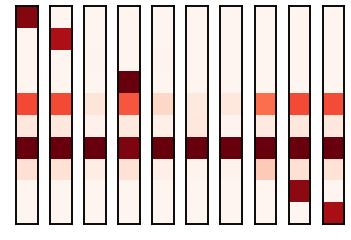

In [70]:
visualize_change(diffs[30])

# Correlation 0.2 Beta 1

In [6]:
current_device = torch.device("cuda:3")
batch_size = 64
seed = 123
beta = 1.0
z_dim = 10

checkpoint_path="../train-logs/jscmodel_bvae_w1corr02_dsprites/epoch=25-step=299520.ckpt"

acts_for_dsprites_full, dsprites_full_dataset, model_dsprites_full  = load_model_and_data_and_get_activations(
                    dset_name='dsprites_full', dset_path='../datasets', 
                    batch_size=batch_size, z_dim=z_dim , beta=beta, 
                    checkpoint_path=checkpoint_path, current_device=current_device, 
                    activation_with_label=False, seed=123,  batches=10, l_zero_reg=False
    )

dsprites_full_loader = DataLoader(dsprites_full_dataset, batch_size=batch_size, shuffle = False,drop_last=True)
img, labels = next(dsprites_full_loader.__iter__())



Experiment class: cpu
Model class: cpu
Loaded 737280 images


  0%|▏                                                                                                                                                                                                   | 10/10368 [00:00<16:03, 10.75it/s]


In [7]:
diffs = check_correlated_dimensions(img.to(current_device), model_dsprites_full, current_device)

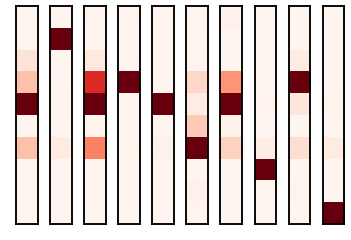

In [10]:
visualize_change(diffs[0])

In [11]:
#plt.imshow(diffs[0][0].cpu().numpy().T, cmap='Reds')

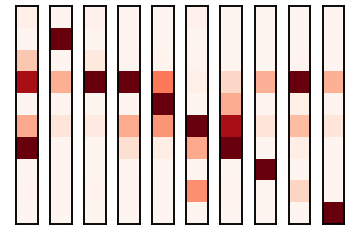

In [77]:
visualize_change(diffs[1])

In [12]:
#plt.imshow(diffs[1][0].cpu().numpy().T, cmap='Reds')

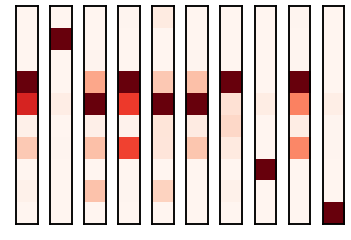

In [79]:
visualize_change(diffs[2])

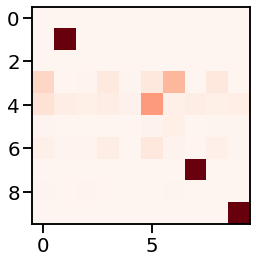

In [80]:
plt.imshow(diffs[2][0].cpu().numpy().T, cmap='Reds')

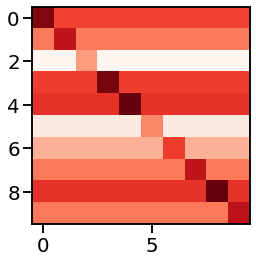

In [81]:
plt.imshow(diffs[2][2].cpu().numpy().T, cmap='Reds')

# 50 epochs dsprites 0.2 corr beta=1

In [5]:
current_device = torch.device("cuda:0")
dataset='dsprites_correlated'
checkpoint_path="../models/epoch=49-step=576000.ckpt"
os.environ['DISENTANGLEMENT_LIB_DATA'] = '../datasets'

model, activations, data_loader  = model_and_activations(current_device,  dataset, checkpoint_path, l_dim=5, num_batches=150,
                                                        activation_type='for_scatter')

Initialize [CorrelatedDSpritesDataset] with 737280 examples. Shape (737280, 64, 64).


In [6]:
mus, labels = activations

In [7]:
len(mus), len(labels), type(model)

(9600, 9600, bvae_experiment.BVAEExperiment)

In [8]:
from sklearn.ensemble import GradientBoostingClassifier

mus, labels = activations
gbt_models = {}
feature_imps = []
train_acc = []
test_acc = []
factors = ["shape", "scale", "orientation", "position x", "position y"]
N = len(mus)
Ntest = 1000 #points for test
T = N - Ntest

for current_factor in range(len(factors)):
    
    X_train, X_test = mus[:T, :], mus[T:, :] 
    y_train, y_test = labels[:T, current_factor], labels[T:, current_factor]

    gbt_models[factors[current_factor]] = GradientBoostingClassifier().fit(X_train, y_train)

    feature_imps.append(gbt_models[factors[current_factor]].feature_importances_.reshape(1, X_train.shape[1]))
    
    train_acc.append(np.mean(gbt_models[factors[current_factor]].predict(X_train) == y_train))
    test_acc.append(np.mean(gbt_models[factors[current_factor]].predict(X_test) == y_test))

[0.8168604651162791, 0.6844186046511628, 0.8196511627906977, 0.8502325581395349, 0.8287209302325581]
[0.76, 0.522, 0.265, 0.396, 0.313]


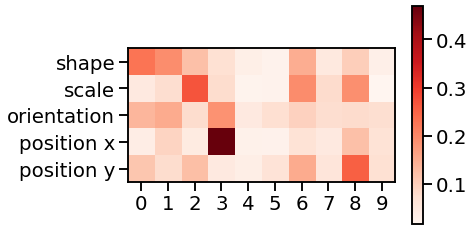

In [9]:
feature_imps_cat =np.concatenate(feature_imps, axis=0)
plt.imshow(feature_imps_cat, cmap='Reds')
plt.colorbar()
yt = plt.yticks(ticks=range(len(factors)), labels=factors)
xt = plt.xticks(ticks=range(10), labels=range(10))
print(train_acc)
print(test_acc)

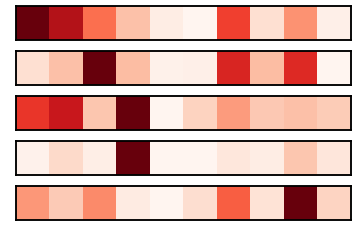

In [10]:
fig, ax = plt.subplots(5,1)
for i in range(5):
    ax[i].imshow(feature_imps_cat[i].reshape(1,10), cmap='Reds')
    ax[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

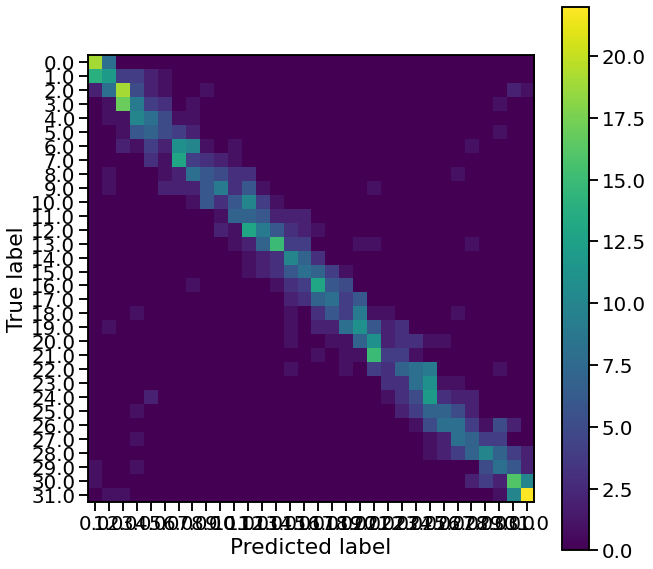

In [13]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(gbt_models['position y'], mus[T:, :], labels[T:, 4], ax=ax, include_values=False)

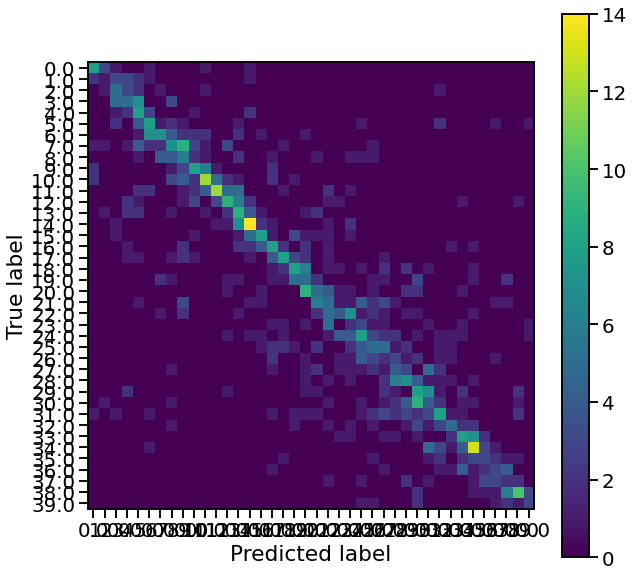

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(gbt_models['orientation'], mus[T:, :], labels[T:, 2], ax=ax, include_values=False)

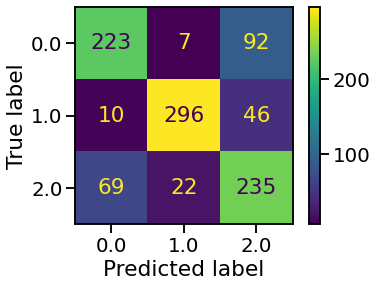

In [14]:
plot_confusion_matrix(gbt_models['shape'], mus[T:, :], labels[T:, 0])

In [9]:
def pairwise_dimension_sactter_plot(mus, labels, xdim, ydim, ldim):
    label_names = ["shape", "scale", "orientation", "position x", "position y"]
    sc = plt.scatter(mus[:, xdim], mus[:, ydim], cmap='YlGn', c=labels[:,ldim], s=5) #, norm=CenteredNorm(), s=3)
    plt.colorbar(sc)
    plt.xlabel(f"z_{xdim}")
    plt.ylabel(f"z_{ydim}")
    plt.title(f'Pairwise wrt {label_names[ldim]}')

In [24]:
#pairwise_dimension_sactter_plot(mus, labels, 1, 3, 2)


In [25]:
#pairwise_dimension_sactter_plot(mus, labels, 1, 3, 3)

In [15]:
imgs, labels = next(data_loader.__iter__())

In [53]:
def _generate_perturbed_copies(vector, dims_to_perturb=None, perturb_mode = 'fixed', fixed_val=None):
    """
    Assumes that vector is of shape (vector_dim, )
    Returns (vector_dim, vector_dim) shaped vector where in (i, vector_dim)
    perturb_mode: 'fixed','relative-min','relative-max' 
    """

    perturbed_copies = []

    for d in range(vector.shape[0]):
        if dims_to_perturb is not None and d not in dims_to_perturb:
                continue
        
        vector_d = vector.clone()
        lim = vector_d[d] / 2
        min_val, max_val = vector_d[d] - lim, vector_d[d] + lim + 0.1
        
        if perturb_mode == 'relative-max':    
            vector_d[d] = vector_d[d] + max_val
        
        if perturb_mode == 'relative-min':
            vector_d[d] = vector_d[d] - min_val
        
        if perturb_mode == 'fixed':
            vector_d[d] = vector_d[d] + fixed_val

        perturbed_copies.append(vector_d)

    return torch.stack(perturbed_copies, dim=0)
    
def check_correlated_dimensions(image_batch, vae_model, current_device, perturb_value=None, perturb_mode='fixed'):
    """
    Train a normal Beta-VAE network on the correlated data
    Once it has been trained, pass a batch of B examples and do the following:

    For each example X:
        Pass it thru network to get latent activations then
        For each latent dim l from 1 to L do:
            perturb unit l which gives an image X_l
            pass X_l again thru the network and record the perturbed mean \mu_l

    For each dimension see if passing the image again leads to a change in any dimension other than the perturbed one (correlation)

    Ideally, we expect only the unit associated with the originally perturned dimension to change.

    If changing unit m consistently results in changes in unit n then we conclude that those two dimensions are correlated.

    We can then introduce a layer before that and connect these two dims to a unit in prev layer.
    """

    
    with torch.no_grad():
        
        sq_diff_batch = []
        #fwd_pass_results = vae_model.model.forward(image_batch, current_device=current_device)
        mus_orig, logvars_orig = vae_model.model.encode(image_batch)
        #x_recon_orig, mu_orig = fwd_pass_results['x_recon'], fwd_pass_results['mu'] 

        # for each example X, perturb unit l=1 to L 
        for mu in mus_orig:
            # (dim(mu), mu)
            mus_perturbed = _generate_perturbed_copies(mu, perturb_mode=perturb_mode,fixed_val=perturb_value)
            
            # generate and image from these perturbed means
            # (dim(mu), X.shape)
            x_recons_perturbed = vae_model.model.decode(mus_perturbed, current_device=current_device)
            # pass images again and compare with mu_perturbed
            # (dim(mu), mu)
            mus_perturbed_recon, _ = vae_model.model.encode(x_recons_perturbed, current_device=current_device)

            sq_diff = (mus_perturbed_recon - mus_perturbed).pow(2)
            sq_diff_batch.append((sq_diff, mus_perturbed_recon, mus_perturbed, x_recons_perturbed))

        return sq_diff_batch



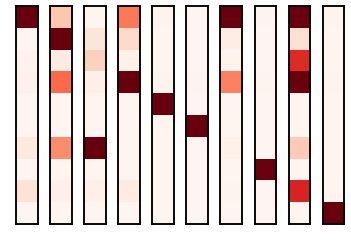

In [54]:
diffs = check_correlated_dimensions(imgs.to(current_device), model, current_device, perturb_value=1.5, perturb_mode='fixed')
visualize_perturbed_dims(diffs[0])

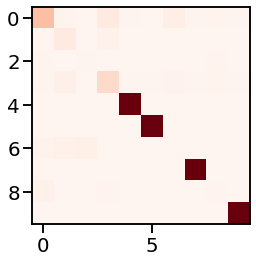

In [55]:
plt.imshow(diffs[0][0].cpu().numpy().T, cmap='Reds')

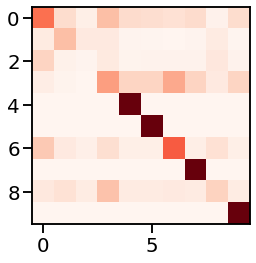

In [22]:
plt.imshow( torch.abs(diffs[0][1] - diffs[0][2]).cpu().numpy().T, cmap='Reds')

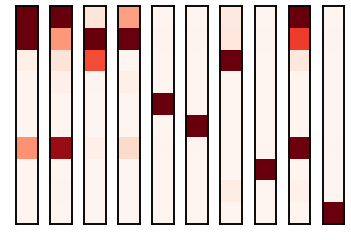

In [23]:
visualize_perturbed_dims(diffs[1])

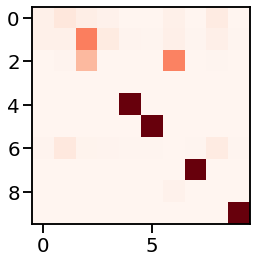

In [24]:
plt.imshow(diffs[1][0].cpu().numpy().T, cmap='Reds')

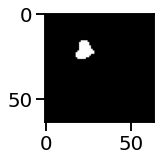

In [44]:
anchor_image = imgs[33]
fig, ax = plt.subplots(figsize=(2,2))
ax.imshow(anchor_image.permute(1,2,0), cmap='gray')
anchor_image = anchor_image.unsqueeze(0).to(current_device)

In [45]:
#for i in range(10):
#    show_traversal_plot(model, anchor_image, limit=2, interp_step=1/5, dim=i, mode='relative')

Visualizing latent space from -3.12 to 2.98, with center at 3.05
Visualizing latent space from -3.93 to 2.17, with center at 3.05
Visualizing latent space from -3.45 to 2.65, with center at 3.05
Visualizing latent space from -3.77 to 2.33, with center at 3.05
Visualizing latent space from -3.44 to 2.66, with center at 3.05


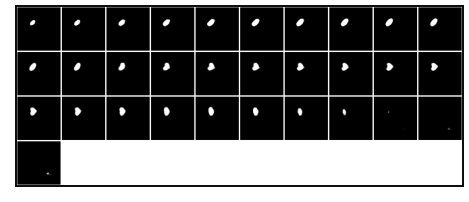

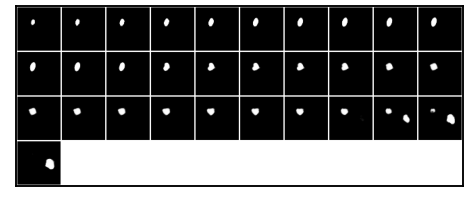

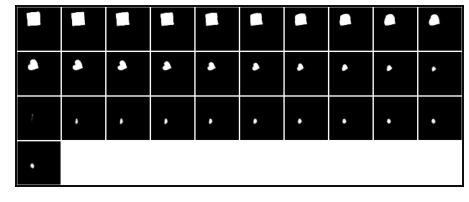

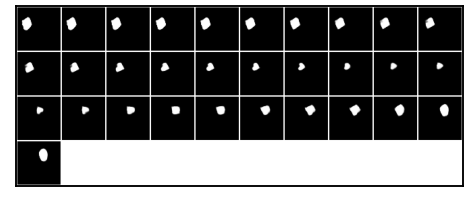

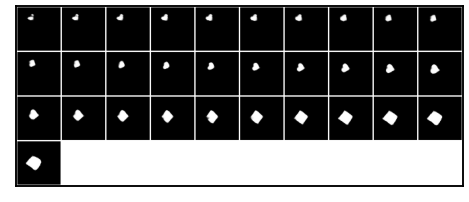

In [50]:
LIMIT = 3

show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=0, mode='relative',
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=1, mode='relative',
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=2, mode='relative',
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=3, mode='relative',
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=8, mode='relative',
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))

Visualizing latent space from -3.12 to 2.98, with center at 3.05
Visualizing latent space from -3.93 to 2.17, with center at 3.05
Visualizing latent space from -3.45 to 2.65, with center at 3.05
Visualizing latent space from -3.77 to 2.33, with center at 3.05
Visualizing latent space from -3.44 to 2.66, with center at 3.05


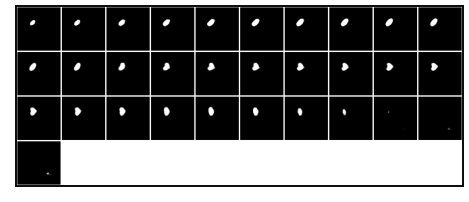

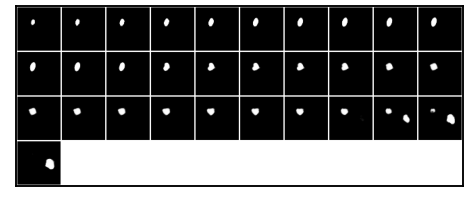

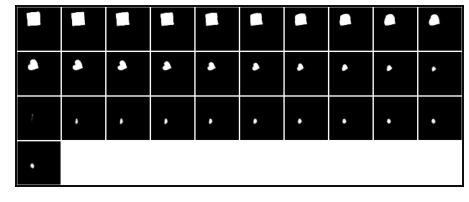

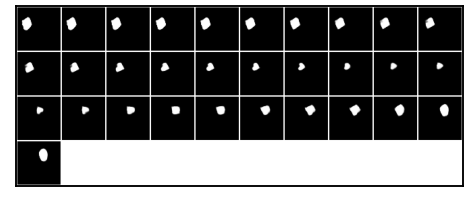

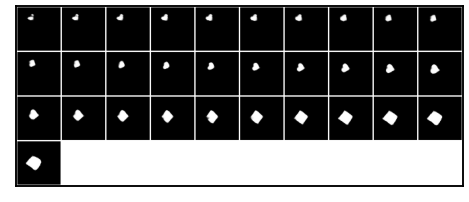

In [51]:
LIMIT = 3

show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=0,
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=1,
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=2,
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=3,
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=8,
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))

Visualizing latent space from -3.00 to 3.10, with center at 3.05
Visualizing latent space from -3.01 to 3.09, with center at 3.05
Visualizing latent space from -3.25 to 2.85, with center at 3.05
Visualizing latent space from -3.00 to 3.10, with center at 3.05
Visualizing latent space from -3.00 to 3.10, with center at 3.05


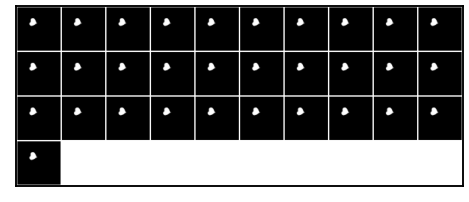

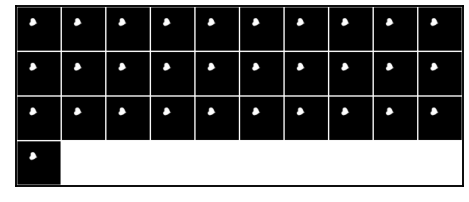

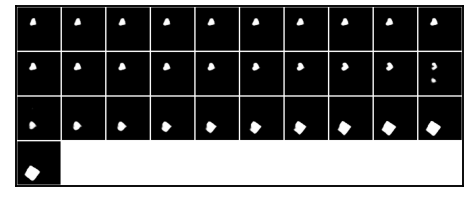

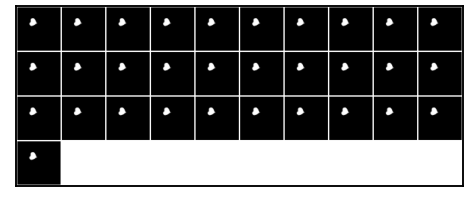

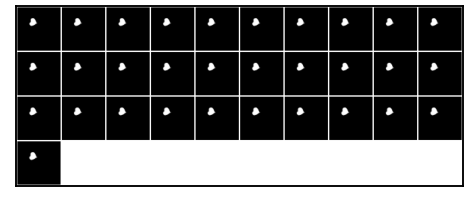

In [52]:
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=4, mode='relative',
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=5, mode='relative',
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=6, mode='relative',
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=7, mode='relative',
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=9, mode='relative',
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))



Visualizing latent space from -3.00 to 3.10, with center at 3.05
Visualizing latent space from -3.01 to 3.09, with center at 3.05
Visualizing latent space from -3.25 to 2.85, with center at 3.05
Visualizing latent space from -3.00 to 3.10, with center at 3.05
Visualizing latent space from -3.00 to 3.10, with center at 3.05


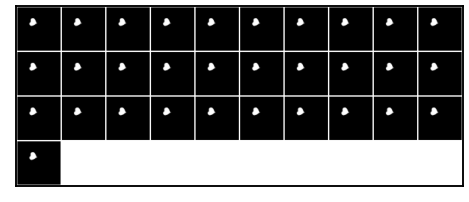

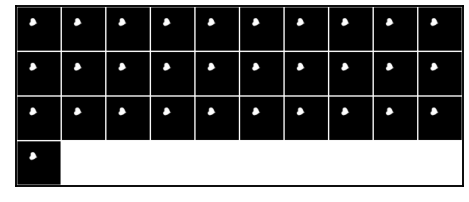

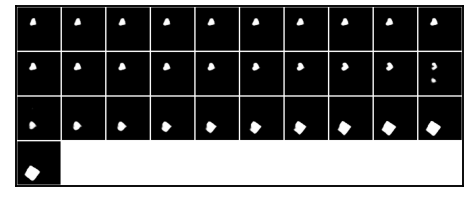

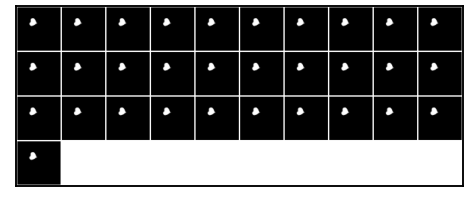

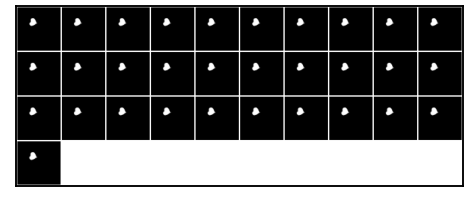

In [48]:
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=4, 
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=5, 
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=6, 
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=7, 
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
show_traversal_images(model, anchor_image, limit=LIMIT, interp_step=1/5, dim=9,
                    layer_to_explore='z1', model_type='bvae',nrow=10, figsize=(8, 10))
